In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def rotate_image(image, angle, center=None, scale=1.0):
    """
    Xoay ảnh với một góc nhất định.
    
    Parameters:
    - image: Ảnh đầu vào.
    - angle: Góc xoay (đơn vị độ).
    - center: Điểm xoay (nếu None, sử dụng giữa ảnh).
    - scale: Tỷ lệ phóng to/thu nhỏ (mặc định là 1.0).
    
    Returns:
    - Ảnh đã xoay.
    """
    # Nếu center là None, đặt center ở giữa ảnh
    if center is None:
        center = (image.shape[1] // 2, image.shape[0] // 2)

    # Tạo ma trận xoay
    M = cv2.getRotationMatrix2D(center, angle, scale)

    # Áp dụng xoay
    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    return rotated_image

In [182]:
def draw(image, locations, w, h, color=(0, 255, 0), thickness=1):
    for pt in zip(*locations[::-1]):
        pt = (int(pt[0]), int(pt[1]))
        cv2.rectangle(image, pt, (pt[0] + w, pt[1] + h), color, thickness)
    return image, len(locations[0])

In [163]:
def template_matching(image, template, down_threshold=0.65, up_threshold=1, 
                      resize_temp=False, min_scale_x=0.8, max_scale_x=1.2, min_scale_y=0.8, max_scale_y=1.2, num_scales=50,
                      rotate_temp=False, min_angle=-90, max_angle=90, num_angles=50,
                      maskH=None, maskW=None):
    """
    Hàm thực hiện template matching để tìm mẫu trong ảnh.
    
    Tham số:
    - image: Ảnh lớn.
    - template: Ảnh mẫu.
    - threshold (float): Ngưỡng xác định độ khớp (mặc định là 0.8).

    Trả về:
    - image: Ảnh đã được tô đen vùng khớp.
    - locations: Danh sách tọa độ các vùng khớp.
    """
    image = image
    template = template

    if resize_temp and not rotate_temp:
        scales_x = np.linspace(min_scale_x, max_scale_x, num_scales)
        scales_y = np.linspace(min_scale_y, max_scale_y, num_scales)
        locations = [np.empty(0), np.empty(0)]

        for fx in scales_x:
            for fy in scales_y:
                resized_template = cv2.resize(template, None, fx=fx, fy=fy)
                result = cv2.matchTemplate(image, resized_template, cv2.TM_CCOEFF_NORMED)

                loc = np.where((up_threshold >= result) & (result >= down_threshold))
                locations[0] = np.concatenate([locations[0], loc[0]])
                locations[1] = np.concatenate([locations[1], loc[1]])

                if maskH:
                    h, w = maskH, maskW
                else:
                    h, w = resized_template.shape[:2]
                image, _ = draw(image, loc, w, h, color=(0, 0, 0), thickness=-1)

    elif rotate_temp and not resize_temp:
        angles = np.linspace(min_angle, max_angle, num_angles)[::-1]
        locations = [np.empty(0), np.empty(0)]

        for angle in angles:
            rotated_template = rotate_image(template, angle)
            result = cv2.matchTemplate(image, rotated_template, cv2.TM_CCOEFF_NORMED)

            loc = np.where((up_threshold >= result) & (result >= down_threshold))
            locations[0] = np.concatenate([locations[0], loc[0]])
            locations[1] = np.concatenate([locations[1], loc[1]])

            if maskH:
                h, w = maskH, maskW
            else:
                h, w = rotated_template.shape[:2]
            image, _ = draw(image, loc, w, h, color=(0, 0, 0), thickness=-1)

    elif rotate_temp and resize_temp:
        scales_x = np.linspace(min_scale_x, max_scale_x, num_scales)[::-1]
        scales_y = np.linspace(min_scale_y, max_scale_y, num_scales)[::-1]
        angles = np.linspace(min_angle, max_angle, num_angles)[::-1]
        locations = [np.empty(0), np.empty(0)]
        
        for fx in scales_x:
            for fy in scales_y:
                for angle in angles:
                    resized_template = cv2.resize(template, None, fx=fx, fy=fy)
                    rotated_template = rotate_image(resized_template, angle)
                    result = cv2.matchTemplate(image, rotated_template, cv2.TM_CCOEFF_NORMED)

                    loc = np.where((up_threshold >= result) & (result >= down_threshold))
                    locations[0] = np.concatenate([locations[0], loc[0]])
                    locations[1] = np.concatenate([locations[1], loc[1]])

                    if maskH:
                        h, w = maskH, maskW
                    else:
                        h, w = rotated_template.shape[:2]
                    image, _ = draw(image, loc, w, h, color=(0, 0, 0), thickness=-1)
            
    else:
        result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
        locations = np.where((up_threshold >= result) & (result >= down_threshold))

        if maskH:
            h, w = maskH, maskW
        else:
            h, w = template.shape[:2]
        image, _ = draw(image, locations, w, h, color=(0, 0, 0), thickness=-1)

    return image, locations

In [151]:
def show_img(image, title=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')  # Tắt hiển thị trục
    plt.title(title)
    plt.show()

In [152]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    """
    Phát hiện cạnh trong ảnh sử dụng Canny Edge Detection.
    - low_threshold: Ngưỡng thấp để phát hiện cạnh yếu.
    - high_threshold: Ngưỡng cao để phát hiện cạnh mạnh.
    """
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return edges

In [123]:
def process_match(image, x, y, w, h, locations, down_threshold=0.65, up_threshold=1, 
                  resize_temp=False, min_scale_x=0.8, max_scale_x=1.2, min_scale_y=0.8, max_scale_y=1.2, num_scales=21, 
                  rotate_temp=False, min_angle=-20, max_angle=20, num_angles=21, 
                  maskH=None, maskW=None, 
                  inheritance=True):
    crop_img = image[y:y+h, x:x+w].copy()

    image, loc = template_matching(image, crop_img, down_threshold, up_threshold, 
                                   resize_temp, min_scale_x, max_scale_x, min_scale_y, max_scale_y, num_scales,
                                   rotate_temp, min_angle, max_angle, num_angles, 
                                   maskH=maskH, maskW=maskW)
    if inheritance:
        locations[0] = np.concatenate([locations[0], loc[0]])
        locations[1] = np.concatenate([locations[1], loc[1]])
        return image, locations
    return image, loc

Số lượng cú có mỏ (viền lục): 105
Số lượng mèo (đỏ đặc): 1


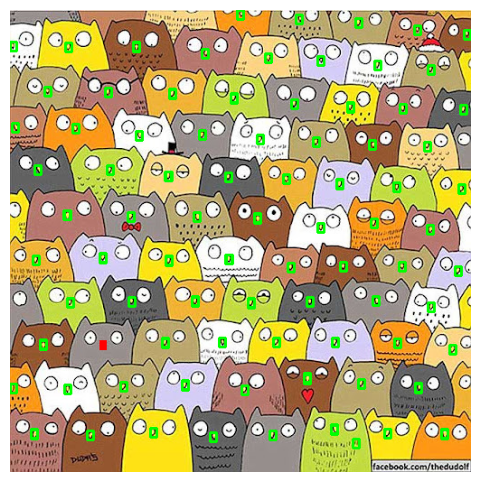

In [124]:
# cat.jpg
image = cv2.imread('cat.jpg')
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = detect_edges(image_grey)

locations = [np.empty(0), np.empty(0)]
w, h = 7, 10

x, y = 61, 36
image_grey, locations = process_match(image_grey, x, y, w, h, locations)

x, y = 27, 172
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.8)

x, y = 325, 403
image_grey, locations = process_match(image_grey, x, y, w, h, locations)

x, y = 203, 224
image_grey, locations = process_match(image_grey, x, y, w, h, locations)

x, y = 212, 43
image_grey, locations = process_match(image_grey, x, y, w, h, locations)

x, y = 340, 51
image_grey, locations = process_match(image_grey, x, y, w, h, locations)

x, y = 0, 414
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.8)

x, y = 0, 35
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.8)

res_image = image.copy()
res_image, count = draw(res_image, locations, w, h, thickness=2)
print('Số lượng cú có mỏ (viền lục):', count)

x, y = 99, 366
image_grey, loc = process_match(image_grey, x, y, w, h, locations, down_threshold=0.8, inheritance=False)
res_image = res_image.copy()
res_image, count = draw(res_image, loc, w, h, color=(0, 0, 255), thickness=-1)
print('Số lượng mèo (đỏ đặc):', count)

show_img(res_image)

Số lượng con mắt (viền lục): 241
Số lượng sinh vật (cú + mèo) (Giả sử 1 con có 2 mắt): 120


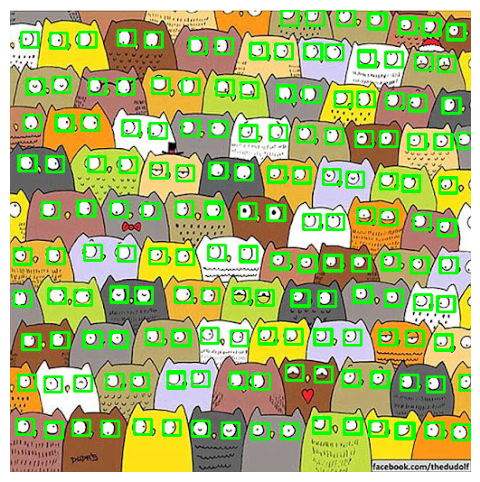

In [125]:
# cat.jpg
image = cv2.imread('cat.jpg')
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = detect_edges(image_grey)

locations = [np.empty(0), np.empty(0)]
w, h = 19, 17

x, y = 115, 260
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.5, up_threshold=1,
                                      min_scale_x=0.78, max_scale_x=1, min_scale_y=0.82, max_scale_y=1,
                                      resize_temp=True, num_scales=5)

x, y = 326, 0
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.7, up_threshold=1,
                                      min_scale_x=0.78, max_scale_x=1, min_scale_y=0.82, max_scale_y=1,
                                      resize_temp=True, num_scales=5)

x, y = 283, 216
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.7, up_threshold=1,
                                      min_scale_x=0.78, max_scale_x=1, min_scale_y=0.82, max_scale_y=1,
                                      resize_temp=True, num_scales=5)

x, y = 496, 404
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.7, up_threshold=1,
                                      min_scale_x=0.78, max_scale_x=1, min_scale_y=0.82, max_scale_y=1,
                                      resize_temp=True, num_scales=5)

res_image = image.copy()
res_image, count = draw(res_image, locations, w, h, thickness=2)
print('Số lượng con mắt (viền lục):', count)
print('Số lượng sinh vật (cú + mèo) (Giả sử 1 con có 2 mắt):', count // 2)

show_img(res_image)

Số lượng chuột (viền lục): 4


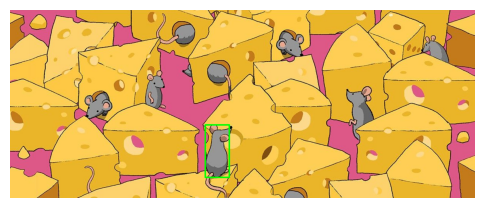

In [126]:
# mouse.jpg
image = cv2.imread('mouse.jpg')[144:]
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = detect_edges(image_grey)

locations = [np.empty(0), np.empty(0)]
w, h = 62, 135

x, y = 502, 297
imagex = image.copy()
imagex, locations = process_match(imagex, x, y, w, h, locations, down_threshold=0.6, up_threshold=1,
                                  resize_temp=True, num_scales=5, maskH=140, maskW=50)

res_image = image.copy()
res_image, count = draw(res_image, locations, w, h, thickness=2)
print('Số lượng chuột (viền lục):', count)

show_img(res_image)

Số lượng thỏ (viền lục): 29


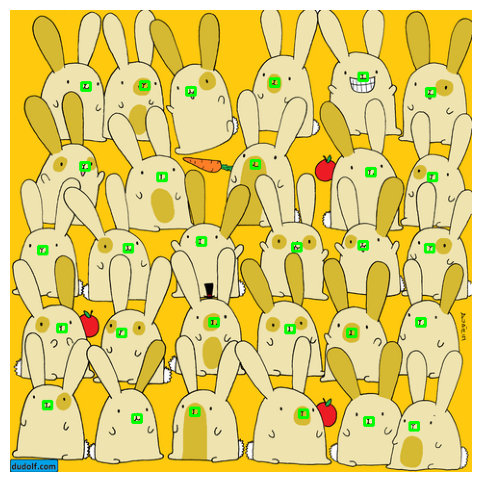

In [213]:
# rabbit2.png
image = cv2.imread('rabbit2.png')
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = detect_edges(image_grey)

locations = [np.empty(0), np.empty(0)]
w, h = 9, 8

x, y = 422, 320
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.71, up_threshold=1,
                                      rotate_temp=True, min_angle=-30, max_angle=30, num_angles=51)

x, y = 118, 243
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.7, up_threshold=1,
                                      rotate_temp=True, min_angle=-30, max_angle=30, num_angles=51)

x, y = 293, 242
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.7, up_threshold=1,
                                      rotate_temp=True, min_angle=-30, max_angle=30, num_angles=51)

x, y = 286, 327
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.7, up_threshold=1,
                                      rotate_temp=True, min_angle=-30, max_angle=30, num_angles=51)

x, y = 74, 75
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.66, up_threshold=1,
                                      rotate_temp=True, min_angle=-30, max_angle=30, num_angles=51)

x, y = 183, 80
w1, h1 = 9, 13
image_grey, locations = process_match(image_grey, x, y, w1, h1, locations, down_threshold=1, up_threshold=1)

x, y = 362, 240
w1, h1 = 9, 12
image_grey, locations = process_match(image_grey, x, y, w1, h1, locations, down_threshold=1, up_threshold=1)

x, y = 431, 243
w1, h1 = 9, 12
image_grey, locations = process_match(image_grey, x, y, w1, h1, locations, down_threshold=1, up_threshold=1)

res_image = image.copy()
res_image, count = draw(res_image, locations, w, h, thickness=2)
print('Số lượng thỏ (viền lục):', count)

show_img(res_image)

In [281]:
def filter(list_point):
    filtered_points = [list_point[0]]

    for p in list_point[1:]:
        add = True
        for fp in filtered_points:
            if p[0] - fp[0] <= 11 and p[1] - fp[1] <= 11:
                add = False
        if add:
            filtered_points.append(p)
    return  filtered_points

Số lượng thỏ: 2


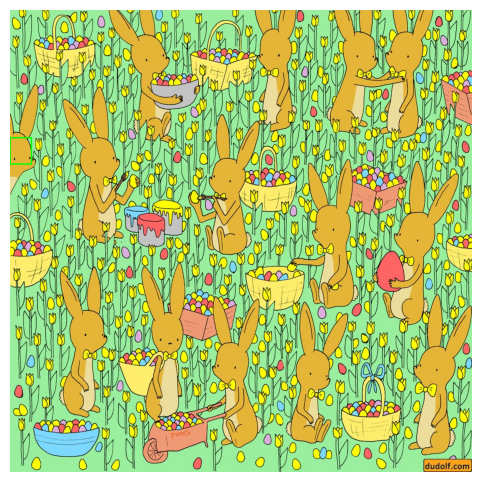

In [285]:
# rabbit.jpeg
image = cv2.imread('rabbit.jpeg')
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = detect_edges(image_grey)

locations = [np.empty(0), np.empty(0)]
w, h = 46, 57

x, y = 0, 276
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=1, up_threshold=1)

# x, y = 448, 334
# image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.28, up_threshold=1)

# locations = filter(list(zip(*locations[::-1])))
print('Số lượng thỏ:', len(locations))

res_image = image.copy()
# for pt in locations:
#     pt = (int(pt[0]), int(pt[1]))
#     cv2.rectangle(res_image, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)
res_image, count = draw(res_image, locations, w, h, thickness=2)
show_img(res_image)

Số lượng dôi ủng: 8


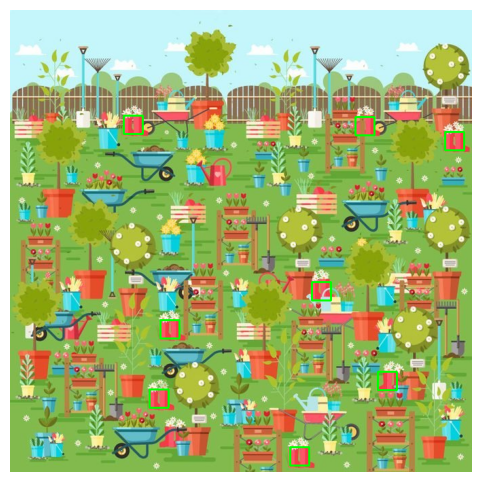

In [312]:
# pair_boot.jpg
image = cv2.imread('pair_boot.jpg')
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = detect_edges(image_grey)

locations = [np.empty(0), np.empty(0)]
w, h = 28, 27

x, y = 205, 561
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.54, up_threshold=1)

x, y = 444, 400
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.9, up_threshold=1)

x, y = 541, 532
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.9, up_threshold=1)

x, y = 228, 614
image_grey, locations = process_match(image_grey, x, y, w, h, locations, down_threshold=0.9, up_threshold=1)

locations = filter(list(zip(*locations[::-1])))
print('Số lượng dôi ủng:', len(locations))

res_image = image.copy()
for pt in locations:
    pt = (int(pt[0]), int(pt[1]))
    cv2.rectangle(res_image, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

show_img(res_image)